In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
# model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# data set

In [5]:
dataset_name = 'Statements1000' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

format_type = 'XML_statements'

In [6]:
# change format
if format_type=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")
  format_type = 'xml'

elif format_type=='XML_questions':
  lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
  truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")
  format_type = 'xml'

elif format_type=='llama':
  lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
  truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

if format_type!='':
  change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [7]:
max_new_tokens = 10
batch_size = 64
torch.cuda.empty_cache()
titles_in_plots = False
save_results = False

In [8]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


16it [00:36,  2.26s/it]                        
16it [00:00, 827.77it/s]              


Success rate when generating truths: 82.11%


16it [00:35,  2.24s/it]                        
16it [00:00, 1025.20it/s]             


Success rate when generating lies:   77.17%
Overlap: 62.45%


In [9]:
print_examples(dataset, n=10)

lie_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>False</answer_type>
<completion>
truth_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>True</answer_type>
<completion>

Examples with format: [statement/question] - [models completion]

The original language of Yalkut Yosef was written in
	GT: Hebrew
	generated lie:   Arabic</completion></

## Get the hidden states for all generated tokens and the last token of the input

In [10]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


In [11]:
dataset['hidden_states_lie'].shape

torch.Size([32, 632, 11, 4096])

In [12]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name, hidden_size=model.config.hidden_size, device=device)

In [13]:
dataset['hidden_states_truth'].shape

torch.Size([32, 632, 11, 4096])

# Entropy

In [14]:
# entropy over layers
# probability of predicted token over layers
source_token_pos=0 # we are tracking the last statement token

num_samples = len(dataset['answer_lie'])
entropy_truth = get_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
entropy_lie = get_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)

# save results to file
results = {'entropy_truth': entropy_truth, 'entropy_lie': entropy_lie}
save_path = f'results/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pth'
torch.save(results, save_path)


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


In [15]:
if save_results:
    # save results to file
    results = {'entropy_truth': entropy_truth, 'entropy_lie': entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)


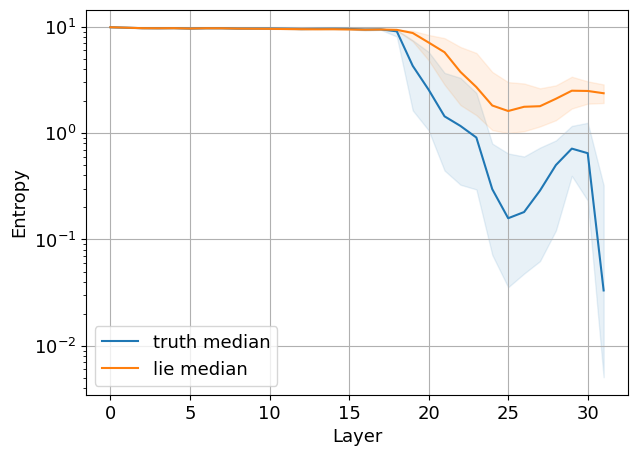

In [16]:
save_path = f'plots/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pdf'
title = f'Entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_truth, entropy_lie, save_path=save_path, title=title, y_label='Entropy')

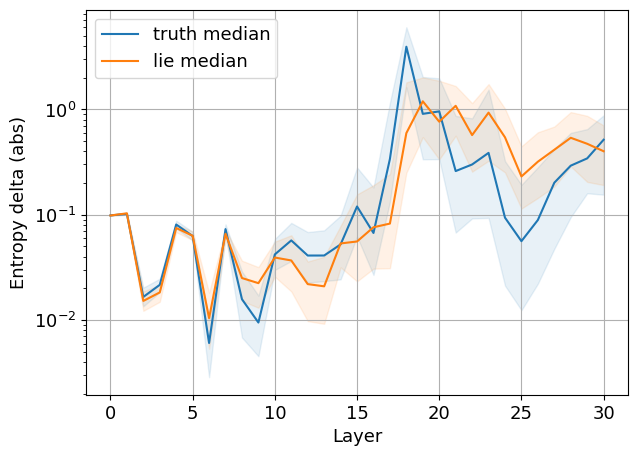

In [17]:
entropy_rate_truth = (entropy_truth[1:]-entropy_truth[:-1]).abs()
entropy_rate_lie = (entropy_lie[1:]-entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_rate_truth, entropy_rate_lie, save_path=save_path, title=title, y_label='Entropy delta (abs)')

# Cross entropy

In [18]:
cross_entropy_truth = get_cross_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
cross_entropy_lie = get_cross_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)

100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


In [19]:
if save_results:
    # save results to file
    results = {'cross_entropy_truth': cross_entropy_truth, 'cross_entropy_lie': cross_entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

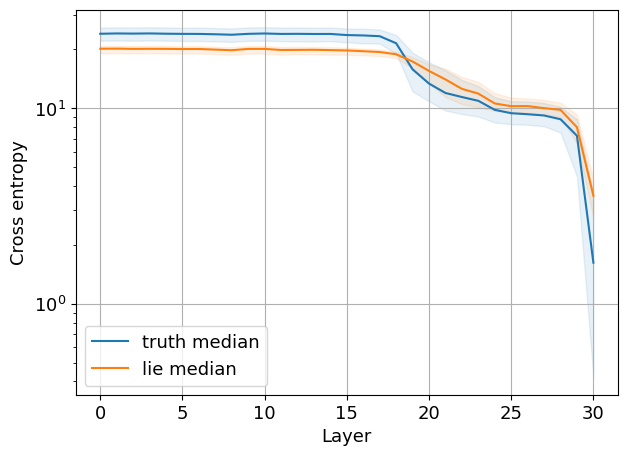

In [20]:
save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pdf'
title = f'Cross entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_truth, cross_entropy_lie, plot_all_curves=False, save_path=save_path, title=title, y_label='Cross entropy', scale='log')

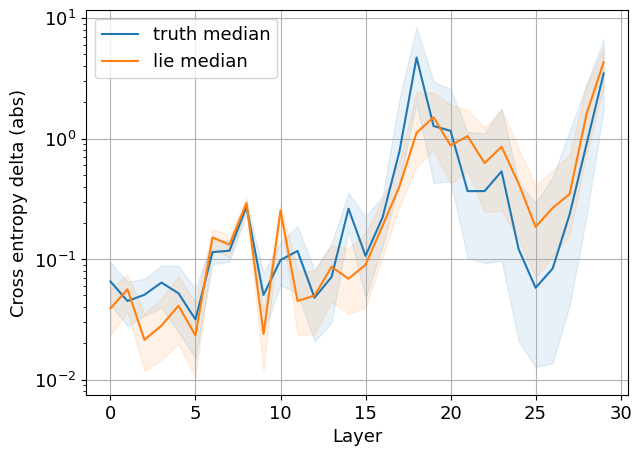

In [21]:
cross_entropy_rate_truth = (cross_entropy_truth[1:]-cross_entropy_truth[:-1]).abs()
cross_entropy_rate_lie = (cross_entropy_lie[1:]-cross_entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Cross entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_rate_truth, cross_entropy_rate_lie, plot_all_curves=False, 
                save_path=save_path, title=title, y_label='Cross entropy delta (abs)')

# Probability

In [22]:
dataset['hidden_states_truth'].shape

torch.Size([32, 632, 11, 4096])

In [23]:
source_token_pos=0 # we are tracking the last statement token
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,source_token_pos]
prob_truth = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,source_token_pos]
prob_lie = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


In [24]:
if save_results:
    # save results to file
    results = {'prob_truth': prob_truth, 'prob_lie': prob_lie, 
               'prob_lie_track_truth_token': prob_lie_track_truth_token, 'prob_truth_track_lie_token': prob_truth_track_lie_token}
    save_path = f'results/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

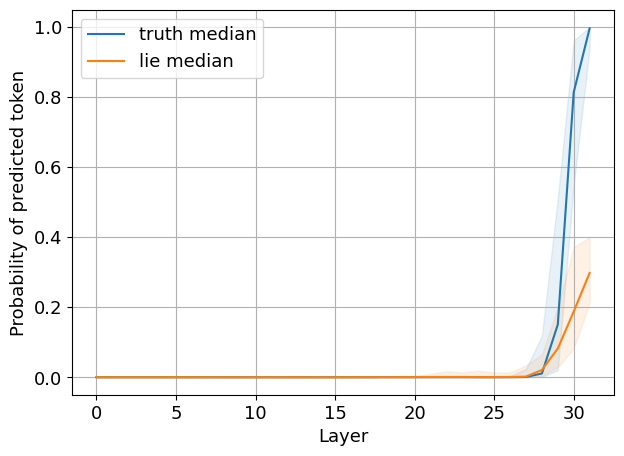

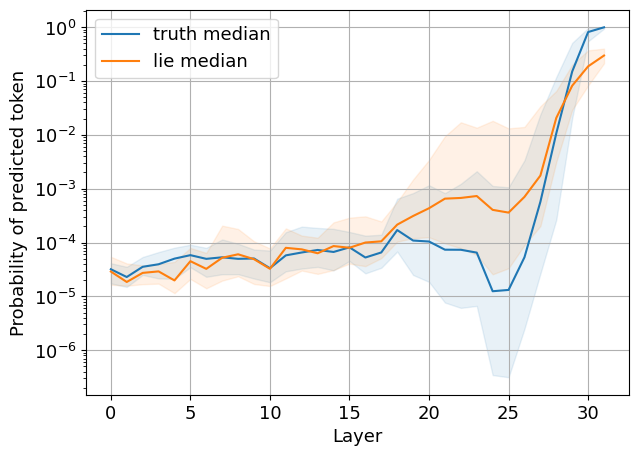

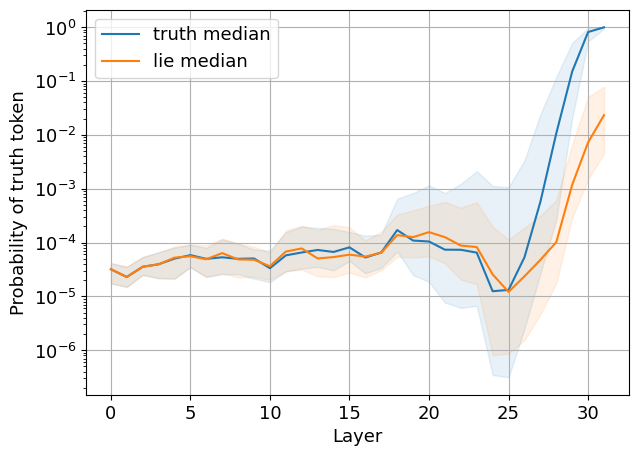

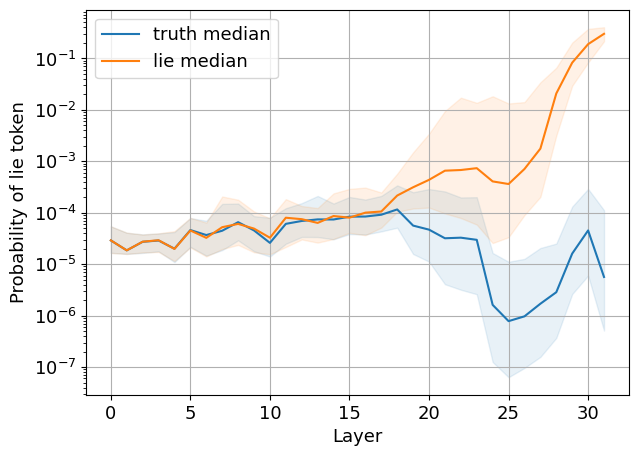

In [25]:
title = f'Token probability {dataset_name}' if titles_in_plots else None

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_linear.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear')
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_log.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='log')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_truth_token.pdf'
plot_median_mean(prob_truth, prob_lie_track_truth_token, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of truth token')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_lie_token.pdf'
plot_median_mean(prob_truth_track_lie_token, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of lie token')

In [26]:

# accumulated probability of top k tokens
k = 10
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

source_token_pos=0 # we are tracking the last statement token

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, source_token_pos]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, source_token_pos]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=top_k_lie_tokens.indices[:,i])

# plot_median_mean(top_k_prob_truth.sum(dim=0), top_k_prob_lie.sum(dim=0), plot_all_curves=False, save_path=None, 
#                 title=f'{dataset_name} after last statement token', y_label=f'Probability sum of top {k} predicted tokens')

100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


In [27]:
# print examples of top k tokens

In [28]:
if save_results:
    # save results to file
    results = {'top_k_prob_truth': top_k_prob_truth, 'top_k_prob_lie': top_k_prob_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_top_k_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

In [29]:
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values

In [30]:
prob_truth_means[0, -1]

tensor(0.9143)

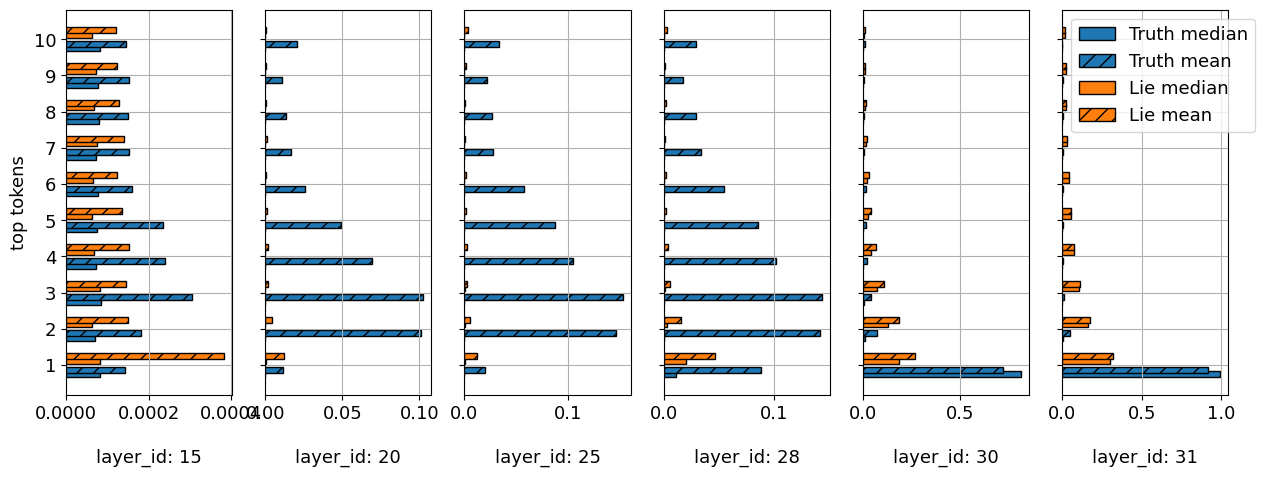

In [31]:
selected_layers = [15, 20, 25, 28, 30, 31]
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_top_{k}_tokens.pdf'
title = f'Probability of top {k} output tokens {dataset_name}' if titles_in_plots else None
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=title, save_path=save_path)

In [32]:
torch.cuda.empty_cache()
import gc
gc.collect()

47029

In [33]:
k=10
success = dataset['success']
truth_scenarios = dataset['truth_scenario'][success]
lie_scenarios = dataset['lie_scenario'][success]
batch_size = 64
multivariate_truth_1, multivariate_truth_2 = get_multivariate(model, tokenizer, truth_scenarios, batch_size, k=k)
multivariate_lie_1,  multivariate_lie_2 = get_multivariate(model, tokenizer, lie_scenarios, batch_size, k=k)

100%|██████████| 10/10 [03:00<00:00, 18.06s/it]


In [34]:
if save_results:
    # save results to file
    results = {'multivariate_truth_1': multivariate_truth_1, 'multivariate_truth_2': multivariate_truth_2,
                'multivariate_lie_1': multivariate_lie_1, 'multivariate_lie_2': multivariate_lie_2}
    save_path = f'results/{short_model_name}_{dataset_name}_multivariate_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

In [35]:
multivariate_truth_1.shape, multivariate_truth_2.shape

(torch.Size([632, 10]), torch.Size([632, 10, 10]))

In [36]:
(multivariate_truth_1==0).sum()

tensor(0)

In [37]:
# entropy of first column:
entropy_multivariate_truth_1 = (-(multivariate_truth_1*torch.log(multivariate_truth_1)).sum(-1)).nanmean()
entropy_multivariate_lie_1 = (-(multivariate_lie_1*torch.log(multivariate_lie_1)).sum(-1)).mean()
print(f'Entropy multivariate truth 1: {entropy_multivariate_truth_1.item()}')
print(f'Entropy multivariate lie 1: {entropy_multivariate_lie_1.item()}')

# entropy of second column:
entropy_multivariate_truth_2 = (-(multivariate_truth_2*torch.log(multivariate_truth_2)).sum(-1)).nanmean(dim=0)
entropy_multivariate_lie_2 = (-(multivariate_lie_2*torch.log(multivariate_lie_2)).sum(-1)).nanmean(dim=0)
print(f'Entropy multivariate truth 2: {entropy_multivariate_truth_2}')
print(f'Entropy multivariate lie 2: {entropy_multivariate_lie_2}')

Entropy multivariate truth 1: 0.2420654296875
Entropy multivariate lie 1: 1.6513671875
Entropy multivariate truth 2: tensor([0.0505, 0.2953, 0.3789, 0.4362, 0.4197, 0.4966, 0.4905, 0.5250, 0.5155,
        0.5722])
Entropy multivariate lie 2: tensor([0.1367, 0.1516, 0.2129, 0.2641, 0.2843, 0.3059, 0.3248, 0.3708, 0.3755,
        0.3917])


In [38]:
# combine probabilities:
multivariate_truth = multivariate_truth_1.unsqueeze(2) * multivariate_truth_2
multivariate_lie = multivariate_lie_1.unsqueeze(2) * multivariate_lie_2

captured probability mass truth: 0.99
captured probability mass lies: 0.86


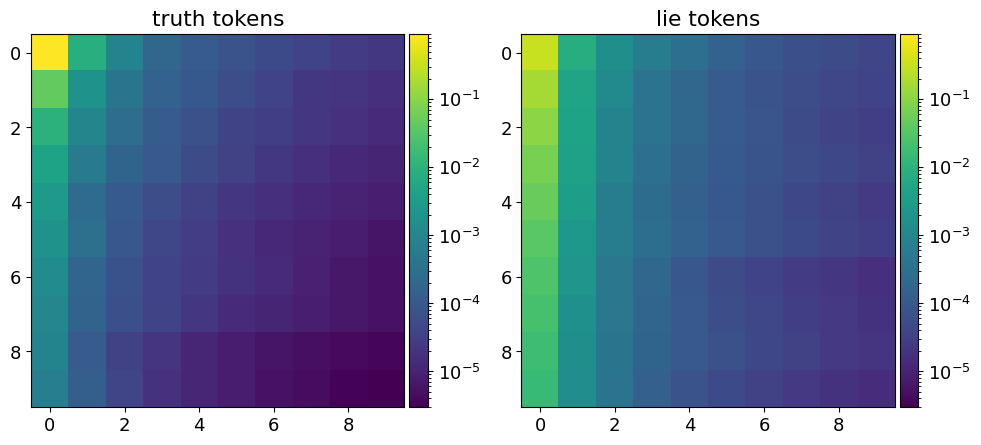

In [39]:
print(f'captured probability mass truth: {multivariate_truth.sum(dim=(1,2)).mean():.2g}')
print(f'captured probability mass lies: {multivariate_lie.sum(dim=(1,2)).mean():.2g}')

title = f'Multivariate prob. distr. P(Output=(i,j)|Input) {dataset_name}' if titles_in_plots else None
save_path = f'plots/{short_model_name}_{dataset_name}_multivariate_prob_{lens_type}_{format_type}.pdf'
plot_distance_matrix(multivariate_truth.mean(0), multivariate_lie.mean(0), sub_titles=['truth tokens', 'lie tokens'], 
                     sup_title=title, norm=True, remove_diagonal=False, save_path=save_path)


In [56]:
top_k_truth_tokens.indices.shape, top_k_lie_tokens.indices.shape

(torch.Size([632, 10]), torch.Size([632, 10]))

In [79]:
def check_arrays(array1, array2):
    result = [1 if a.lower().startswith(b.lower()) or b.lower().startswith(a.lower()) else 0 for a, b in zip(array1, array2)]
    return result

top_k_strings_truth = np.empty((top_k_truth_tokens.indices.shape), dtype='object')
top_k_strings_lie = np.empty((top_k_lie_tokens.indices.shape), dtype='object')
for i in range(k):
    top_k_strings_truth[:,i]= tokenizer.batch_decode(top_k_truth_tokens.indices[:,i])
    top_k_strings_lie[:,i]= tokenizer.batch_decode(top_k_lie_tokens.indices[:,i])

top_k_consider_truth = torch.zeros((top_k_truth_tokens.indices.shape))
top_k_consider_lie = torch.zeros((top_k_lie_tokens.indices.shape))
for i in range(k):
    top_k_consider_truth[:,i] = torch.FloatTensor(check_arrays(top_k_strings_truth[:,i], top_k_strings_truth[:,0]))
    top_k_consider_lie[:,i] =  torch.FloatTensor(check_arrays(top_k_strings_lie[:,i], top_k_strings_lie[:,0]))



In [101]:
# sum over all prob that match tokens that are considered
new_shape = (k, 1, num_samples)
prob_truth_sums = (top_k_prob_truth*torch.transpose(top_k_consider_truth, 0,1).unsqueeze(1)).sum(dim=0)
prob_lie_sums = (top_k_prob_lie*torch.transpose(top_k_consider_lie, 0,1).unsqueeze(1)).sum(dim=0)

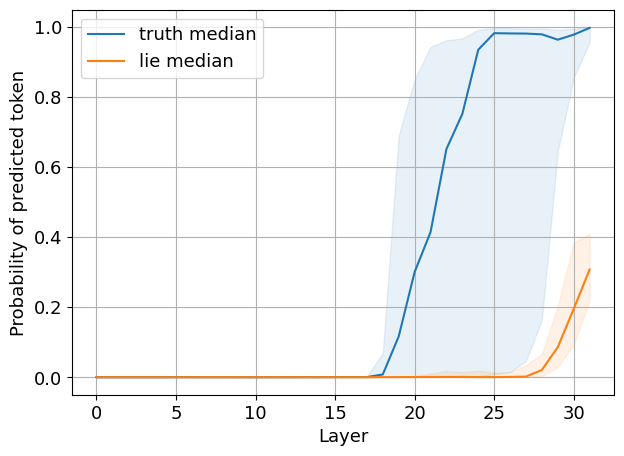

In [102]:
title = f'Token probability {dataset_name} summed' if titles_in_plots else None

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_linear.pdf'
plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear')
# save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_log.pdf'
# plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
#                 title=title, y_label='Probability of predicted token', scale='log')

# KL divergence

In [40]:
dataset['hidden_states_truth'].shape

torch.Size([32, 632, 11, 4096])

In [41]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='last')

100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


In [42]:
if save_results:
    # save results to file
    results = {'KL_truth': KL_truth, 'KL_lie': KL_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

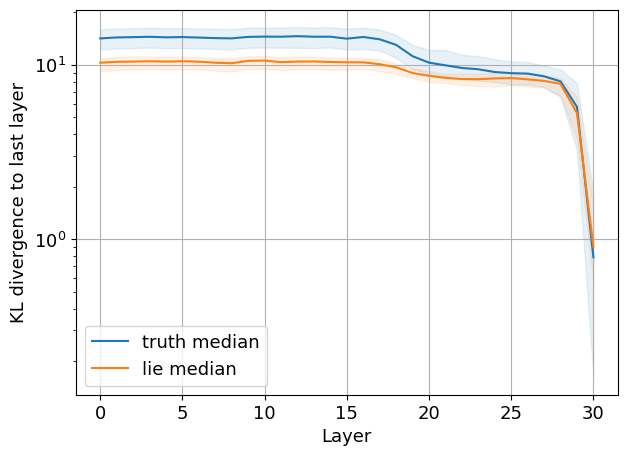

In [43]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pdf'
title = f'KL divergence {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to last layer')


In [44]:
diff = cross_entropy_truth - entropy_truth[:-1]

(diff-KL_truth).abs().max(), (diff-KL_truth).abs().mean()

(tensor(9.5367e-06), tensor(1.1005e-06))

In [45]:
KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])

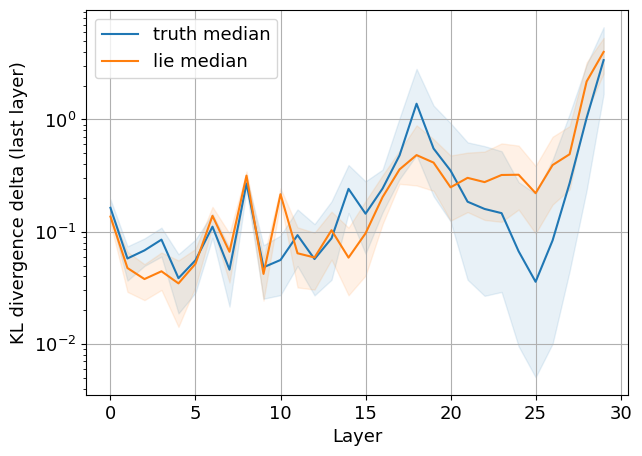

In [46]:

save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_{lens_type}_{format_type}.pdf'
title = f'KL divergence delta {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (last layer)')

In [47]:
KL_truth_next = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='next')
KL_lie_next = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='next')

100%|██████████| 31/31 [00:32<00:00,  1.03s/it]


In [48]:
if save_results:
    # save results to file
    results = {'KL_truth_next': KL_truth_next, 'KL_lie_next': KL_lie_next}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

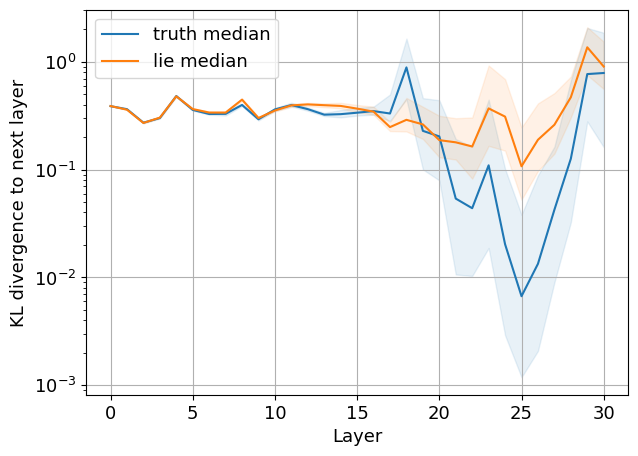

In [49]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_next, KL_lie_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to next layer')

In [50]:
KL_truth_rate_next = torch.abs(KL_truth_next[1:]-KL_truth_next[:-1])
KL_lie_rate_next = torch.abs(KL_lie_next[1:]-KL_lie_next[:-1])

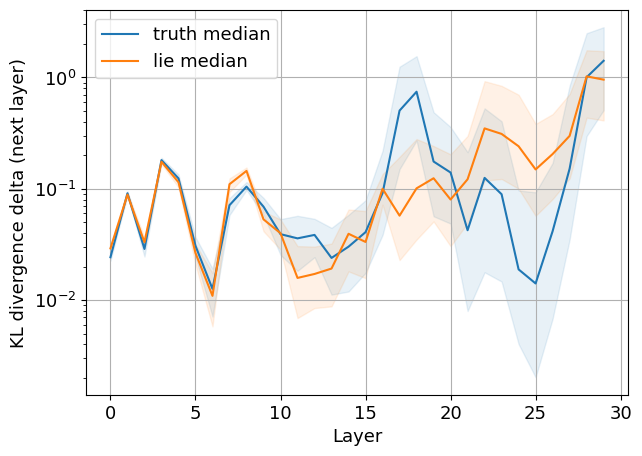

In [51]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence rate delta next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate_next, KL_lie_rate_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (next layer)')

# Similarity of 10 most likely output tokens

In [52]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

In [53]:
if save_results:
    # save results to file
    results = {'truth_token_dist': truth_token_dist, 'lie_token_dist': lie_token_dist,
               'truth_token_sim': truth_token_sim, 'lie_token_sim': lie_token_sim}
    save_path = f'results/{short_model_name}_{dataset_name}_token_dist_sim_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

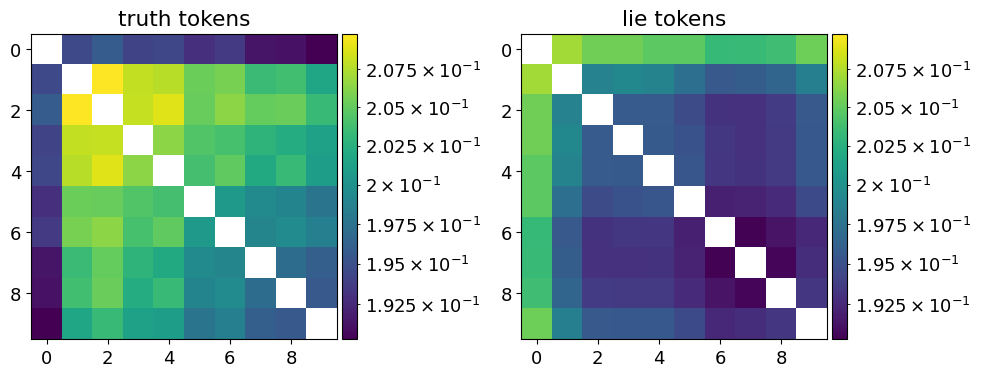

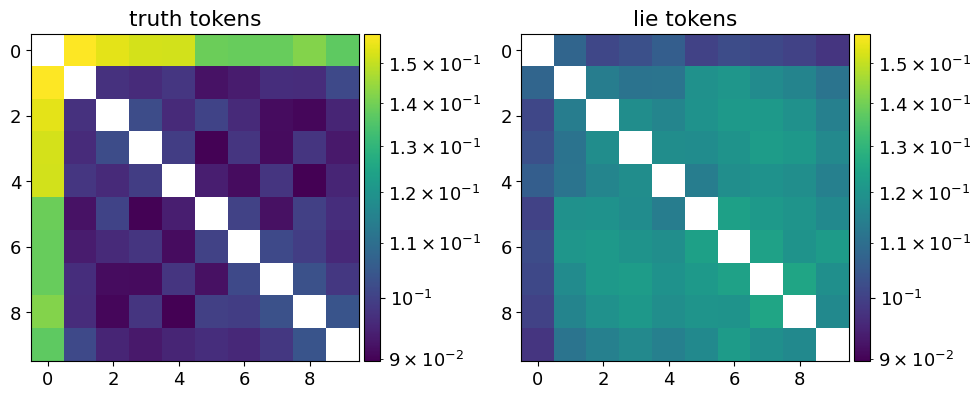

In [54]:
save_path = f'plots/{short_model_name}_{dataset_name}_token_dist_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise eucl. distances of top {k} tokens" if titles_in_plots else None
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)

save_path = f'plots/{short_model_name}_{dataset_name}_token_sim_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise cosine similarity of top {k} tokens" if titles_in_plots else None

plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)